In [52]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

In [136]:
import imp
en = imp.load_source('encode', '/home/arturas/Projects/ProteoDNN/ProteoDNN/Utils/encode.py')

### Data encoding

In [25]:
oxy = pd.read_csv('data/OxidationAll.txt', sep=',')

In [32]:
oxy.dtypes

Peptide                        object
Proteins                       object
Identification Score          float64
Pair Score                    float64
[L]ID                           int64
[L]Modifications              float64
[L]Mass                       float64
[L]Charge                       int64
[L]m/z                        float64
[L]Retention Time (min)       float64
[H]ID                           int64
[H]Modifications               object
[H]Mass                       float64
[H]Charge                       int64
[H]m/z                        float64
[H]Retention Time (min)       float64
Mass Difference (Observed)    float64
Mass Difference (Expected)    float64
Mass Difference (Delta)       float64
Retention (Delta)             float64
Unnamed: 20                   float64
dtype: object

In [93]:
oxy['[L]Retention Time (min)'].max()

99.959999999999994

In [91]:
oxy_ = oxy[(oxy['[L]Retention Time (min)'] > 20) & (oxy['[L]Retention Time (min)'] < 80)]

In [186]:
peptides = [np.array(en.encode_aa_counts(pep)).reshape(-1,1) for pep in oxy_.iloc[:,0]]
peptides = np.concatenate(peptides,axis=1)
peptides = peptides.T

In [187]:
ret_delta = oxy_.iloc[:,19]

In [188]:
peptides_norm.shape

(178884, 400)

### Simple model of the retention difference $(\delta t)$

In [189]:
#normalize features
peptides_norm = (peptides - np.mean(peptides, axis=0))/np.std(peptides,axis=0)

In [190]:
def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

Xdat, Ydat = append_bias_reshape(peptides_norm, ret_delta)

/home/arturas/anaconda2/envs/tensorflow/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [143]:
n_dim = Xdat.shape[1]

rnd_indices = np.random.rand(len(Xdat)) < 0.80

train_x = Xdat[rnd_indices]
train_y = Ydat[rnd_indices]
test_x = Xdat[~rnd_indices]
test_y = Ydat[~rnd_indices]

In [147]:
learning_rate = 0.01
training_epochs = 500
cost_history = np.empty(shape=[1],dtype=float)

In [148]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))

init = tf.initialize_all_variables()

In [149]:
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [150]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    

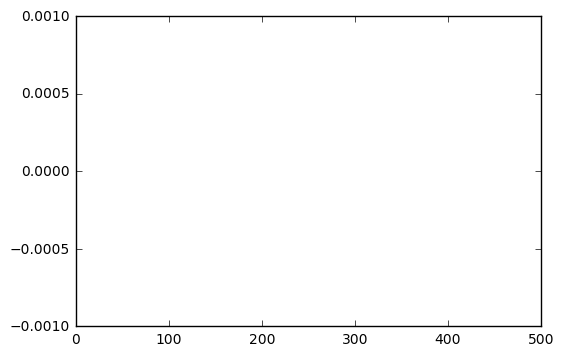

In [151]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

In [152]:
pred_y = sess.run(y_, feed_dict={X: train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse)) 

pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 


MSE: nan
MSE: nan


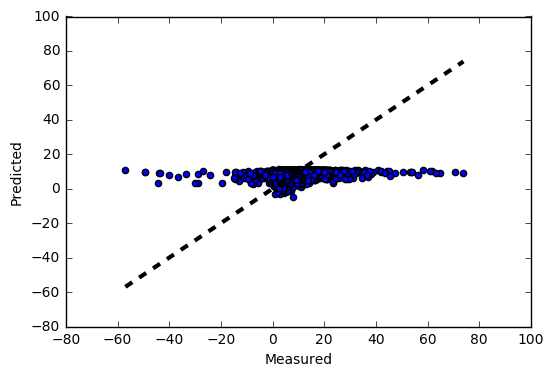

In [112]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#### Since the naive linear model does not work we try a simple NN

In [191]:
#normalize features
peptides_norm = (peptides - np.mean(peptides, axis=0))/np.std(peptides,axis=0)

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

Xdat, Ydat = append_bias_reshape(peptides_norm, ret_delta)

/home/arturas/anaconda2/envs/tensorflow/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [192]:
n_dim = Xdat.shape[1]

rnd_indices = np.random.rand(len(Xdat)) < 0.80

train_x = Xdat[rnd_indices]
train_y = Ydat[rnd_indices]
test_x = Xdat[~rnd_indices]
test_y = Ydat[~rnd_indices]

In [193]:
learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1],dtype=float)

In [194]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])

H1 = tf.placeholder(tf.float32,[None,400])
H1_ = tf.placeholder(tf.float32,[None,400])
#H2 = tf.placeholder(tf.float32,[None,100])

W1 = tf.Variable(tf.zeros([n_dim,400]))
#W2 = tf.Variable(tf.ones([400,200]))
W2 = tf.Variable(tf.zeros([400,1]))

init = tf.initialize_all_variables()

In [198]:
H1 = tf.matmul(X, W1)
H1_ = tf.nn.relu(H1)
y_ = tf.matmul(H1_,W2)

cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [199]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    

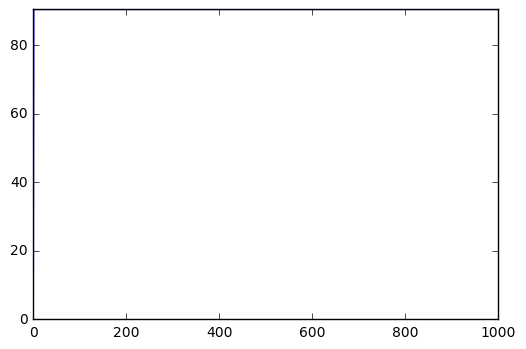

In [200]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

In [201]:
pred_y = sess.run(y_, feed_dict={X: train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse)) 

pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

MSE: 90.3893
MSE: 90.2466


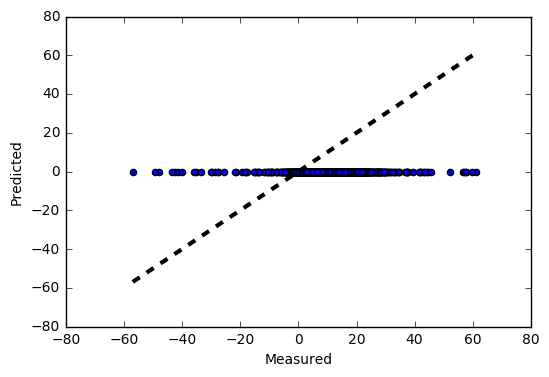

In [202]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()